In [1]:
#Import dependencies
import os
import csv
import numpy as np
import cv2
import keras
import sklearn


C:\Users\david\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, ELU
from keras.layers.convolutional import Cropping2D , Conv2D



In [3]:
#Check Keras version
print ("Using Keras version:",keras.__version__)

#File import and data preprocessing
lines = []
with open('E:/Self driving training/driving_log.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        lines.append(line)
        
#Split data for validation and test 
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)


#Generator function declaration (I LOVE this python feature!)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    name = 'E:/Self driving training/IMG/' + batch_sample[i].split('\\')[-1]
                    image = cv2.imread(name)
                    images.append(image)
                correction = 0.2
                angle = float(batch_sample[3])
                # angle center image
                angles.append(angle)
                # angle left image
                angles.append(angle + correction)
                # angle right image
                angles.append(angle - correction)

            yield shuffle(np.array(images), np.array(angles))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)






Using Keras version: 2.0.8


In [4]:
#Check generator output shape
spitted_data = generator(lines,32)
print(next(spitted_data))

[array([[[[180, 141, 113],
         [180, 141, 113],
         [179, 140, 112],
         ...,
         [214, 251, 255],
         [220, 255, 255],
         [218, 255, 255]],

        [[180, 141, 113],
         [180, 141, 113],
         [180, 141, 113],
         ...,
         [220, 255, 255],
         [220, 255, 255],
         [205, 242, 250]],

        [[181, 142, 114],
         [181, 142, 114],
         [180, 141, 113],
         ...,
         [208, 245, 253],
         [201, 238, 246],
         [190, 227, 235]],

        ...,

        [[187, 201, 195],
         [103, 117, 111],
         [ 97, 111, 105],
         ...,
         [117, 123, 118],
         [124, 130, 125],
         [108, 114, 109]],

        [[102, 116, 110],
         [101, 115, 109],
         [102, 116, 110],
         ...,
         [110, 116, 111],
         [112, 118, 113],
         [ 86,  92,  87]],

        [[125, 139, 133],
         [101, 115, 109],
         [ 88, 102,  96],
         ...,
         [123, 129, 124],
       

In [5]:
#create model


def nvidiaSDC_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

model = nvidiaSDC_model()

#Easier writeup :) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)         36928     
__________

In [6]:
#Training model

model.compile(loss='mse', optimizer='adam')

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)




history_object = model.fit_generator(train_generator,
                    epochs=16,
                    steps_per_epoch=2,
                    validation_data=validation_generator,
                    validation_steps=1)
model.save('model.h5')
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])

Epoch 1/16
2/2 [==============================] - 15s - loss: 0.1367 - val_loss: 0.0631
Epoch 2/16
2/2 [==============================] - 6s - loss: 0.0607 - val_loss: 0.0468
Epoch 3/16
2/2 [==============================] - 6s - loss: 0.0568 - val_loss: 0.0723
Epoch 4/16
2/2 [==============================] - 6s - loss: 0.0540 - val_loss: 0.0586
Epoch 5/16
2/2 [==============================] - 7s - loss: 0.0601 - val_loss: 0.0362
Epoch 6/16
2/2 [==============================] - 6s - loss: 0.0497 - val_loss: 0.0441
Epoch 7/16
2/2 [==============================] - 5s - loss: 0.0453 - val_loss: 0.0585
Epoch 8/16
2/2 [==============================] - 5s - loss: 0.0391 - val_loss: 0.0455
Epoch 9/16
2/2 [==============================] - 5s - loss: 0.0295 - val_loss: 0.0281
Epoch 10/16
2/2 [==============================] - 5s - loss: 0.0419 - val_loss: 0.0429
Epoch 11/16
2/2 [==============================] - 5s - loss: 0.0344 - val_loss: 0.0376
Epoch 12/16
2/2 [=======================

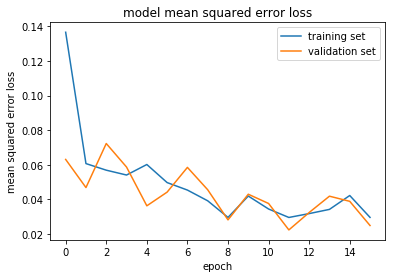

In [8]:
import matplotlib.pyplot as plt
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()